# Introdução

Este trabalho aborda o desenvolvimento de um agente inteligente para planear tarefas. O objetivo é minimizar atrasos, respeitar restrições e apresentar soluções otimizadas de forma visual.

**Objetivos do Projeto:**

* Planear tarefas de forma eficiente, respeitando restrições.
* Criar representações visuais (grafo de precedência e diagrama de Gantt).
* Explorar diferentes soluções.

**Equipa:**

* André Reis (26012)
* Diogo Gonçalves (26021)
* Gonçalo Oliveira (18559)

# Formulação do objetivo

**Objetivo Geral:** Criar um agente que respeite as restrições do problema de planeamento de tarefas e minimize o makespan (tempo total necessário).

**Restrições Consideradas:**

* **Fortes:**
    1. Relações de precedência entre tarefas.
    2. Capacidade de recursos renováveis e não renováveis.

* **Leves**
    1. Minimização do makespan

**Estratégia utilizada:** No código, essas restrições modeladas e processadas durante a fase de parsing. A classe `ProjectScheduler` lida com o parsing de entrada inclui informações sobre precedência, recursos e tarefas. O grafo de precedência é utilizado para validar restrições fortes.

# Importação de Bibliotecas Essenciais
Aqui são importadas bibliotecas fundamentais para o projeto.

In [65]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from typing import List

# Processamento de Dados
Esta classe é responsável por organizar e processar os dados de um ficheiro. A mesma constrói um grafo para representar as relações e um método para ver as informações do ficheiro(diagrama de Gantt).

In [66]:
class ProjectScheduler:
    def __init__(self, file_path):
        # Inicializa a classe com um dicionário para armazenar os dados do projeto.
        self.data = {
            'projects': 0,
            'jobs': 0,
            'horizon': 0,
            'resources': {'renewable': 0, 'nonrenewable': 0},
            'precedence_relations': {},
            'job_details': {},
            'resource_availability': {}
        }
        try:
            # Faz o parsing do ficheiro para extrair os dados
            self.parse_file(file_path)
            # Cria o grafo
            self.graph = self._create_graph()
        except Exception as e:
            # Tratamento de erro durante a inicialização
            print(f"Erro ao inicializar o ProjectScheduler: {str(e)}")
            raise

    # Faz o parsing do ficheiro de entrada para preencher os dados do projeto
    def parse_file(self, file_path):
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                
            sections = content.split('************************************************************************')

            # PARSING: Informações gerais do projeto
            general_info = sections[1]
            projects_match = re.search(r'projects\s*:\s*(\d+)', general_info)
            jobs_match = re.search(r'jobs.*:\s*(\d+)', general_info)
            horizon_match = re.search(r'horizon\s*:\s*(\d+)', general_info)
            
            if not all([projects_match, jobs_match, horizon_match]):
                raise ValueError("Não foi possível encontrar informações gerais no ficheiro")
            
            self.data['projects'] = int(projects_match.group(1))
            self.data['jobs'] = int(jobs_match.group(1))
            self.data['horizon'] = int(horizon_match.group(1))
            
            # PARSING: Recursos renováveis e não renováveis
            resources_match = re.search(r'- renewable\s*:\s*(\d+).*\n*.*- nonrenewable\s*:\s*(\d+)', general_info)
            if resources_match:
                self.data['resources']['renewable'] = int(resources_match.group(1))
                self.data['resources']['nonrenewable'] = int(resources_match.group(2))
            
            # PARSING: Relações de precedência
            precedence_section = None
            for section in sections:
                if '#Precedence relations' in section:
                    precedence_section = section
                    break
            
            if precedence_section:
                lines = precedence_section.strip().split('\n')
                for line in lines:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 4:
                            job_nr = int(parts[0])
                            successors = [int(x) for x in parts[3:]]
                            self.data['precedence_relations'][job_nr] = successors
            
            # PARSING: Detalhes das tarefas
            duration_section = None
            for section in sections:
                if '#Duration' in section:
                    duration_section = section
                    break
            
            if duration_section:
                lines = duration_section.strip().split('\n')
                for line in lines:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 4:
                            job_nr = int(parts[0])
                            duration = int(parts[2])
                            resources = {}
                            for i, resource_value in enumerate(parts[3:]):
                                resources[f'R{i+1}'] = int(resource_value)
                            self.data['job_details'][job_nr] = {
                                'duration': duration,
                                'resources': resources
                            }
            
            # PARSING: Disponibilidade de recursos
            availability_section = None
            for section in sections:
                if '#Resource availability' in section:
                    availability_section = section
                    break
            
            if availability_section:
                lines = availability_section.strip().split('\n')
                for line in lines:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split()
                        if len(parts) >= 2:
                            resource = parts[0]
                            quantity = int(parts[1])
                            self.data['resource_availability'][resource] = quantity
                            
        except FileNotFoundError:
            raise FileNotFoundError(f"Ficheiro não encontrado: {file_path}")
        except Exception as e:
            raise Exception(f"Erro ao fazer parse do ficheiro: {str(e)}")

    # Cria um grafo com base nas relações de precedência
    def _create_graph(self):
        G = nx.DiGraph()

        # Adiciona nós com atributos detalhados
        for job_id, details in self.data['job_details'].items():
            G.add_node(job_id, **details)

        # Adiciona arestas com base nas relações de precedência
        for pred, successors in self.data['precedence_relations'].items():
            for succ in successors:
                G.add_edge(pred, succ)
                
        return G
    
    # Retorna um resumo dos dados do projeto
    def get_project_summary(self):
        return {
            'Total Projects': self.data['projects'],
            'Total Jobs': self.data['jobs'],
            'Time Horizon': self.data['horizon'],
            'Renewable Resources': self.data['resources']['renewable'],
            'Resource Availability': self.data['resource_availability']
        }
    
    # Métodos adicionais para plotar gráficos e diagramas
    def get_job_precedence(self):
        return self.data['precedence_relations']
    
    def get_job_details(self):
        return self.data['job_details']

    def plot_precedence_graph(self):
        try:
            pos = nx.spring_layout(self.graph, k=0.5, iterations=50)
            
            plt.figure(figsize=(10, 6))
            
            nx.draw(self.graph, pos, 
                    with_labels=True,
                    node_color='lightblue',
                    node_size=500,
                    arrows=True,
                    edge_color='gray',
                    font_size=10,
                    font_weight='bold')
            
            
            plt.title("Grafo de Precedência de Tarefas")
            plt.show()
        except Exception as e:
            print(f"Erro ao plotar o grafo: {str(e)}")

    def plot_gantt_chart(self):
        try:
            
            early_start = {node: 0 for node in self.graph.nodes()}
            for node in nx.topological_sort(self.graph):
                predecessors = list(self.graph.predecessors(node))
                if predecessors:
                    early_start[node] = max(early_start[p] + self.data['job_details'][p]['duration'] 
                                        for p in predecessors)

            fig, ax = plt.subplots(figsize=(15, 8))
            
            for i, task in enumerate(self.data['job_details'].keys()):
                start = early_start[task]
                duration = self.data['job_details'][task]['duration']
                ax.barh(i, duration, left=start, height=0.3, 
                       align='center', color='skyblue', alpha=0.8)
                
                ax.text(start + duration/2, i, f'T{task}',
                       ha='center', va='center')

            ax.set_ylim(-1, len(self.data['job_details']))
            ax.set_xlabel('Tempo')
            ax.set_ylabel('Tarefas')
            ax.set_title('Diagrama de Gantt')
            ax.grid(True)
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Erro ao plotar o diagrama de Gantt: {str(e)}")

# Execução e Apresentação dos Resultados
Aqui são carregados os dados de um ficheiro de texto, são também exibidos, um resumo do projeto, um grafo que mostra as relações de precedência e um diagrama de Gantt para visualização gráfica. Isto é realizado para os 3 exemplos dados.
Estes resultados são obtidos através do "early start time" ou seja, os resultados obtidos são a solução mais rápida possivel de realizar os projetos.

Resumo do Projeto:
{'Total Projects': 1, 'Total Jobs': 8, 'Time Horizon': 20, 'Renewable Resources': 2, 'Resource Availability': {'R1': 1, 'R2': 2}}

Relações de Precedência:
{1: [2, 3], 2: [4], 3: [4], 5: [6, 7], 6: [8], 7: [8]} 


Detalhes das Tarefas:
{1: {'duration': 2, 'resources': {'R1': 1, 'R2': 0}}, 2: {'duration': 3, 'resources': {'R1': 0, 'R2': 1}}, 3: {'duration': 4, 'resources': {'R1': 0, 'R2': 1}}, 4: {'duration': 1, 'resources': {'R1': 0, 'R2': 1}}, 5: {'duration': 2, 'resources': {'R1': 1, 'R2': 0}}, 6: {'duration': 3, 'resources': {'R1': 0, 'R2': 1}}, 7: {'duration': 4, 'resources': {'R1': 0, 'R2': 1}}, 8: {'duration': 1, 'resources': {'R1': 0, 'R2': 1}}}


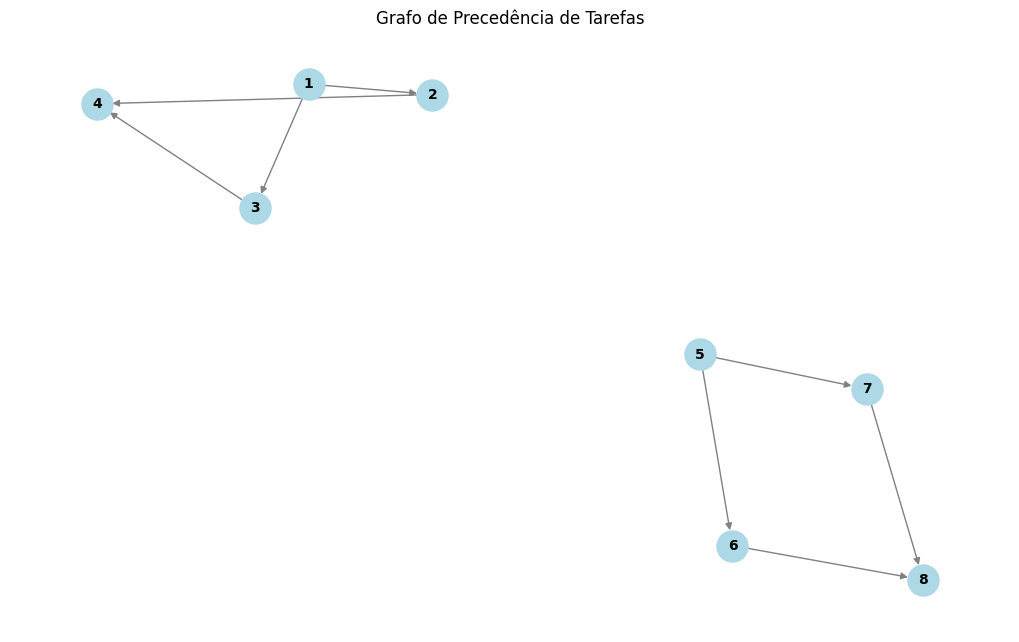

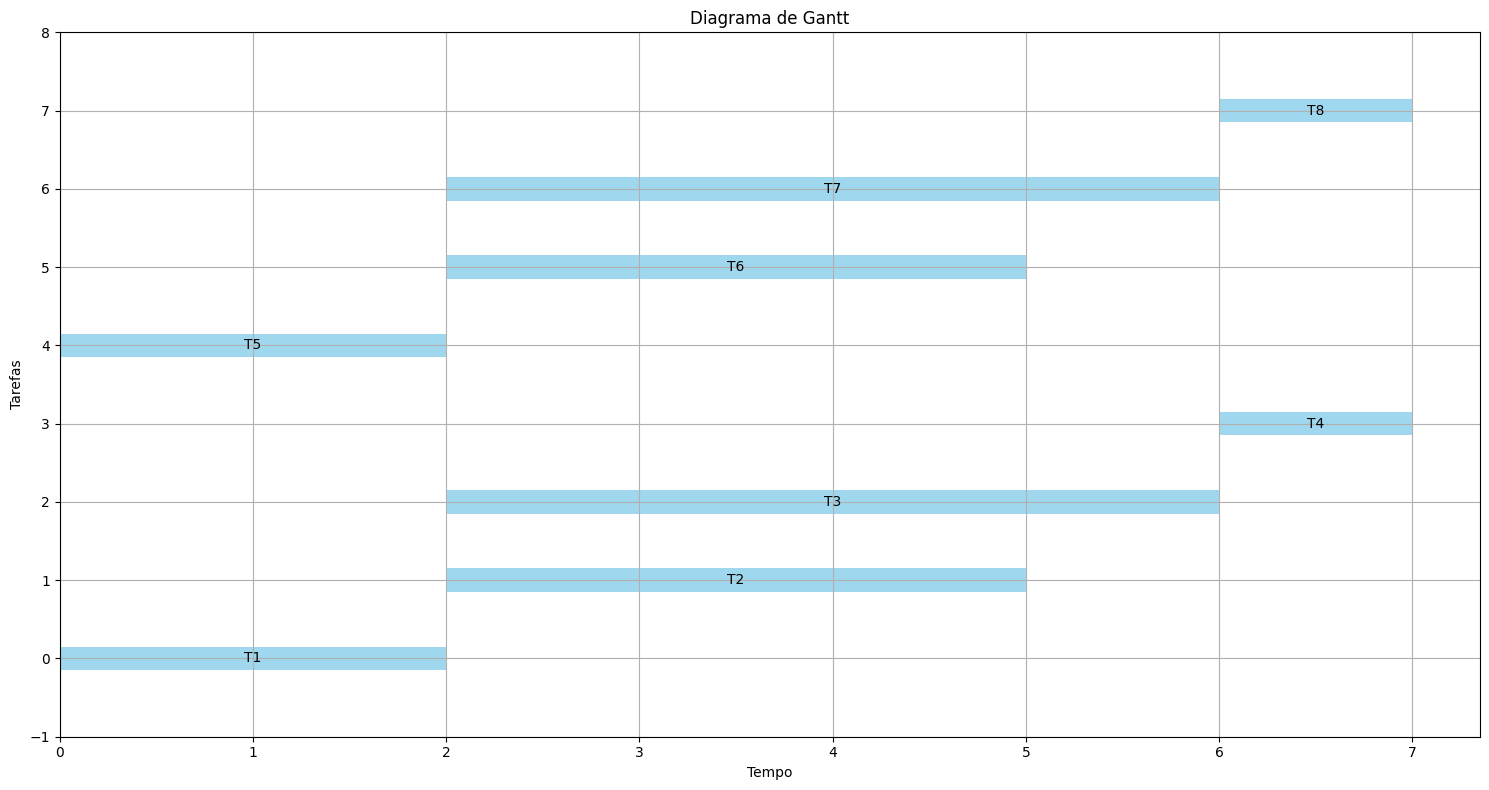

In [67]:
def main():
    try:
        # Especifica o caminho para o ficheiro de configuração a ser processado
        file_path = '8.txt'  

        # Cria uma instância da classe ProjectScheduler e processa o ficheiro
        scheduler = ProjectScheduler(file_path)

        # Exibe um resumo geral do projeto
        print("Resumo do Projeto:")
        print(scheduler.get_project_summary())

        # Exibe as relações de precedência entre as tarefas do projeto
        print("\nRelações de Precedência:")
        print(scheduler.get_job_precedence(), "\n")

        # Exibe os detalhes de cada tarefa, como duração e recursos necessários
        print("\nDetalhes das Tarefas:")
        print(scheduler.get_job_details())

        # Grafo de precedência, representando as dependências entre tarefas
        scheduler.plot_precedence_graph()

        # Diagrama de Gantt, mostrando os tempos de início e duração das tarefas
        scheduler.plot_gantt_chart()
        
    except Exception as e:
        # Captura e exibe qualquer erro ocorrido durante a execução do programa
        print(f"Erro na execução do programa: {str(e)}")

# Invoca a função principal quando o script é executado diretamente
if __name__ == "__main__":
    main()


Resumo do Projeto:
{'Total Projects': 1, 'Total Jobs': 12, 'Time Horizon': 46, 'Renewable Resources': 2, 'Resource Availability': {'R1': 6, 'R2': 4}}

Relações de Precedência:
{1: [2, 3, 4], 2: [5, 6], 3: [10, 11], 4: [9], 5: [7, 8], 6: [10, 11], 7: [9, 10], 8: [9], 9: [12], 10: [12], 11: [12]} 


Detalhes das Tarefas:
{1: {'duration': 0, 'resources': {'R1': 0, 'R2': 0}}, 2: {'duration': 3, 'resources': {'R1': 6, 'R2': 2}}, 3: {'duration': 1, 'resources': {'R1': 0, 'R2': 0}}, 4: {'duration': 8, 'resources': {'R1': 4, 'R2': 0}}, 5: {'duration': 4, 'resources': {'R1': 0, 'R2': 4}}, 6: {'duration': 4, 'resources': {'R1': 0, 'R2': 4}}, 7: {'duration': 6, 'resources': {'R1': 2, 'R2': 0}}, 8: {'duration': 4, 'resources': {'R1': 4, 'R2': 2}}, 9: {'duration': 5, 'resources': {'R1': 3, 'R2': 0}}, 10: {'duration': 7, 'resources': {'R1': 2, 'R2': 1}}, 11: {'duration': 4, 'resources': {'R1': 0, 'R2': 3}}, 12: {'duration': 0, 'resources': {'R1': 0, 'R2': 0}}}


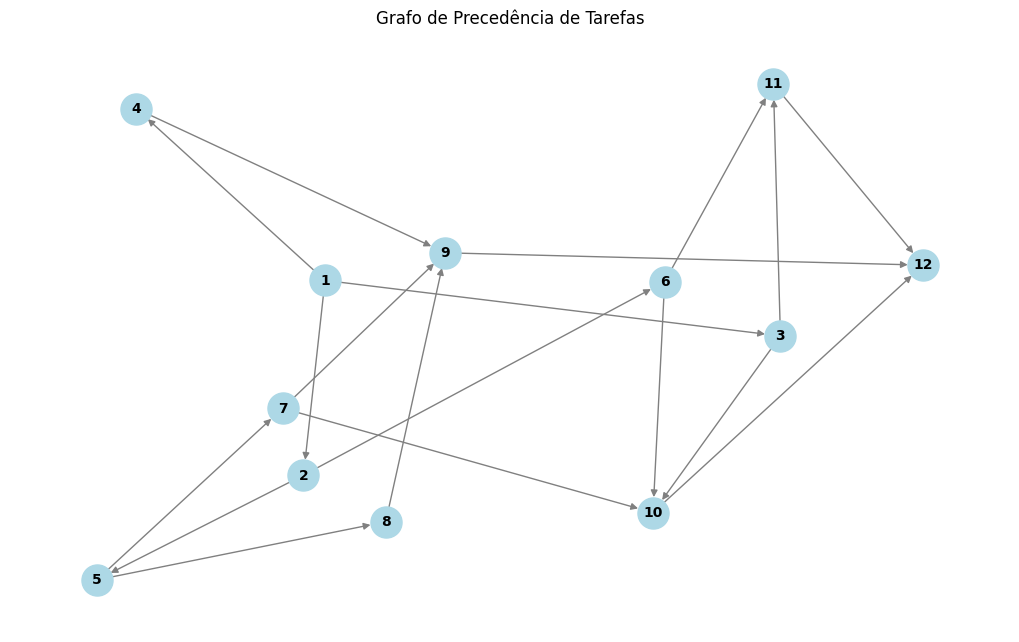

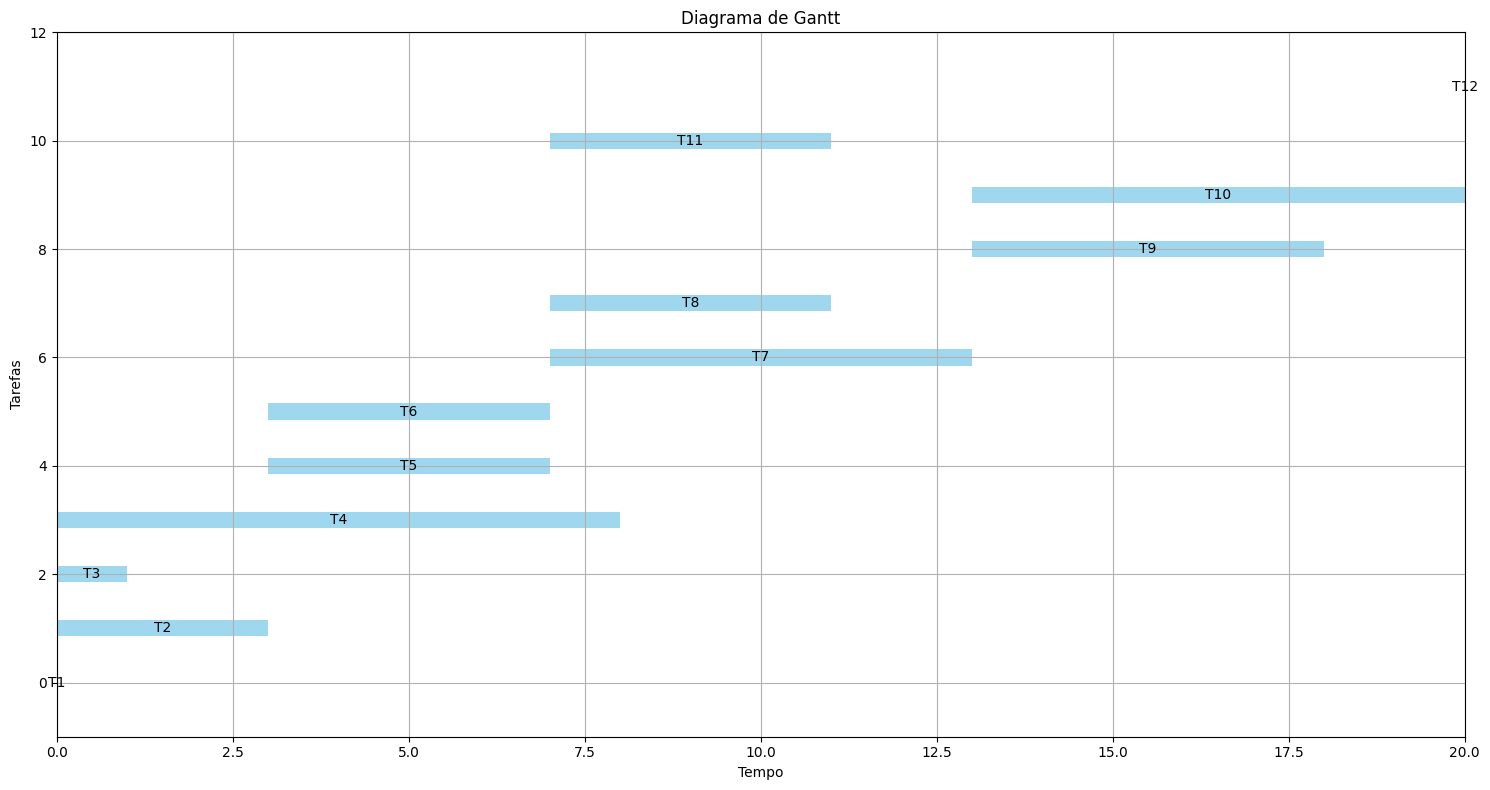

In [68]:
def main():
    try:
        # Especifica o caminho para o ficheiro de configuração a ser processado
        file_path = '10.txt'  

        # Cria uma instância da classe ProjectScheduler e processa o ficheiro
        scheduler = ProjectScheduler(file_path)

        # Exibe um resumo geral do projeto
        print("Resumo do Projeto:")
        print(scheduler.get_project_summary())

        # Exibe as relações de precedência entre as tarefas do projeto
        print("\nRelações de Precedência:")
        print(scheduler.get_job_precedence(), "\n")

        # Exibe os detalhes de cada tarefa, como duração e recursos necessários
        print("\nDetalhes das Tarefas:")
        print(scheduler.get_job_details())

        # Grafo de precedência, representando as dependências entre tarefas
        scheduler.plot_precedence_graph()

        # Diagrama de Gantt, mostrando os tempos de início e duração das tarefas
        scheduler.plot_gantt_chart()
        
    except Exception as e:
        # Captura e exibe qualquer erro ocorrido durante a execução do programa
        print(f"Erro na execução do programa: {str(e)}")

# Invoca a função principal quando o script é executado diretamente
if __name__ == "__main__":
    main()

Resumo do Projeto:
{'Total Projects': 1, 'Total Jobs': 32, 'Time Horizon': 141, 'Renewable Resources': 4, 'Resource Availability': {'R1': 10, 'R2': 8, 'R3': 13, 'R4': 12}}

Relações de Precedência:
{1: [2, 3, 4], 2: [23, 24], 3: [5, 6, 17], 4: [7, 20], 5: [10, 22, 28], 6: [18], 7: [8, 9, 12], 8: [14, 21, 27], 9: [11, 16], 10: [16], 11: [17], 12: [13, 15, 16], 13: [30], 14: [19], 15: [26], 16: [25], 17: [24], 18: [21], 19: [25], 20: [25, 27], 21: [22], 22: [29, 30], 23: [31], 24: [27], 25: [26], 26: [30], 27: [28], 28: [31], 29: [32], 30: [32], 31: [32]} 


Detalhes das Tarefas:
{1: {'duration': 0, 'resources': {'R1': 0, 'R2': 0, 'R3': 0, 'R4': 0}}, 2: {'duration': 1, 'resources': {'R1': 0, 'R2': 0, 'R3': 0, 'R4': 5}}, 3: {'duration': 1, 'resources': {'R1': 0, 'R2': 3, 'R3': 0, 'R4': 0}}, 4: {'duration': 1, 'resources': {'R1': 8, 'R2': 0, 'R3': 0, 'R4': 0}}, 5: {'duration': 7, 'resources': {'R1': 0, 'R2': 0, 'R3': 2, 'R4': 0}}, 6: {'duration': 6, 'resources': {'R1': 0, 'R2': 0, 'R3': 0,

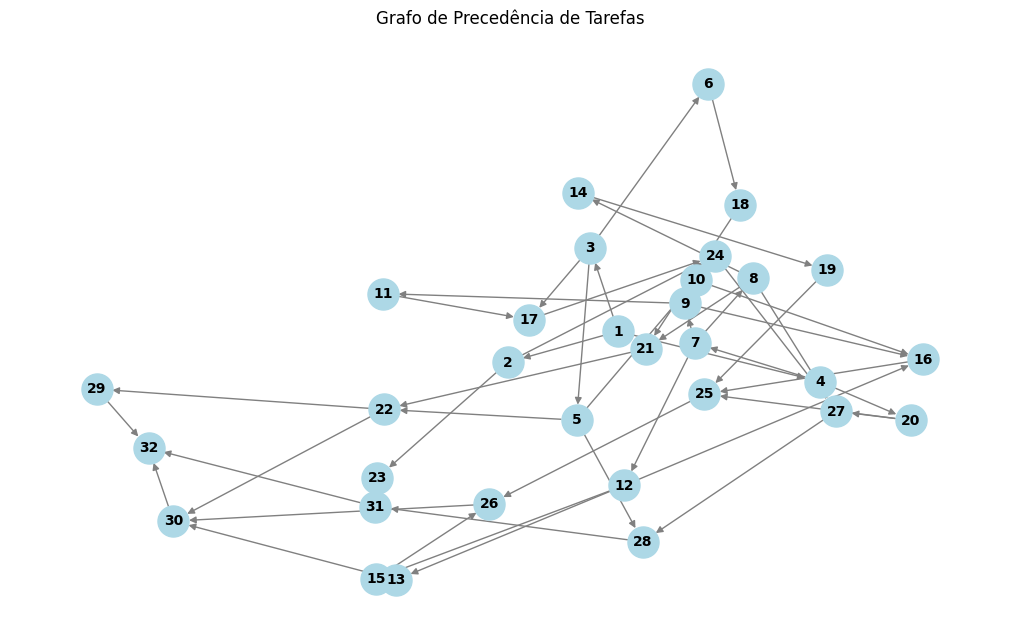

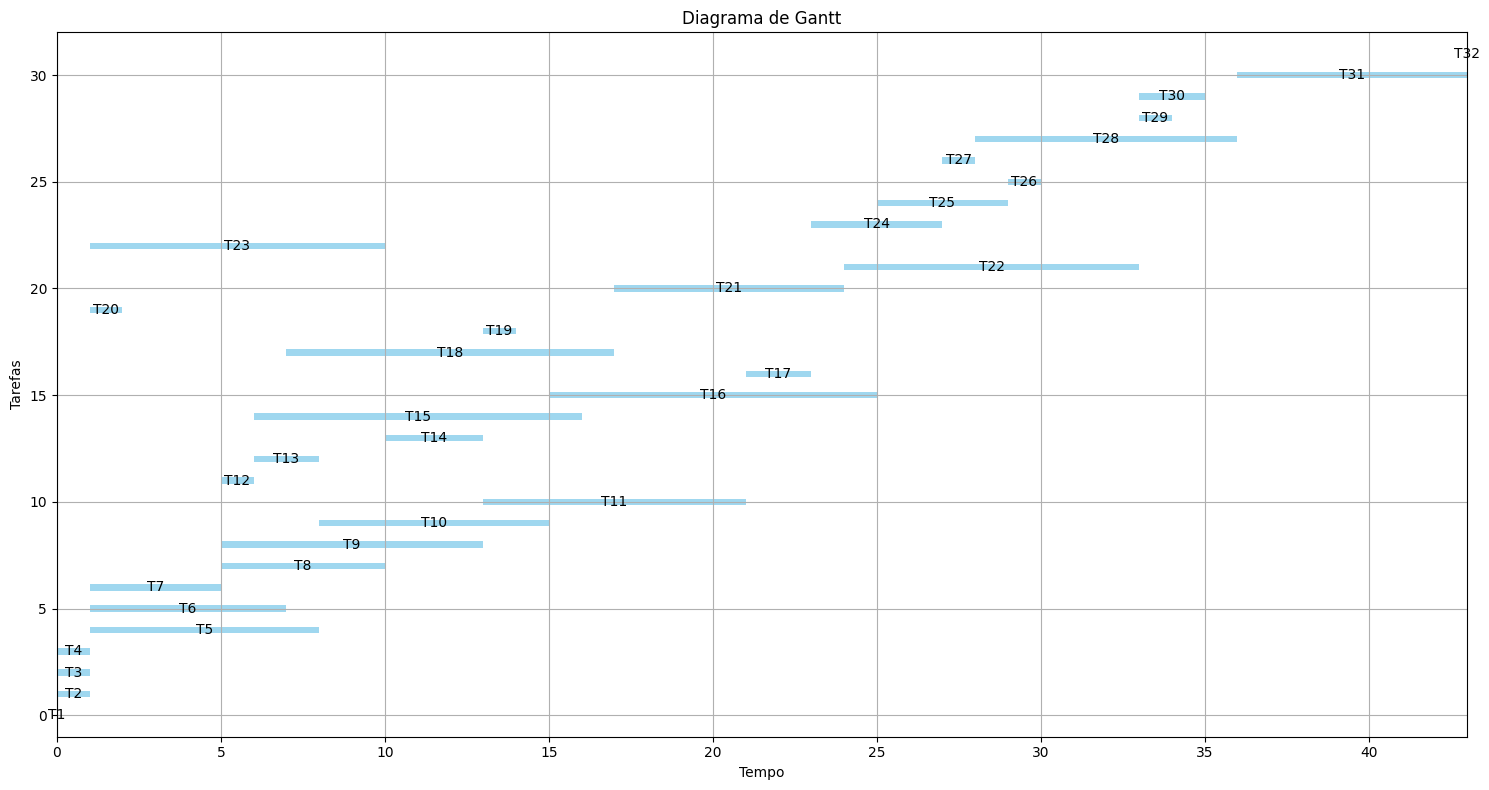

In [69]:
def main():
    try:
        # Especifica o caminho para o ficheiro de configuração a ser processado
        file_path = '30.txt'  

        # Cria uma instância da classe ProjectScheduler e processa o ficheiro
        scheduler = ProjectScheduler(file_path)

        # Exibe um resumo geral do projeto
        print("Resumo do Projeto:")
        print(scheduler.get_project_summary())

        # Exibe as relações de precedência entre as tarefas do projeto
        print("\nRelações de Precedência:")
        print(scheduler.get_job_precedence(), "\n")

        # Exibe os detalhes de cada tarefa, como duração e recursos necessários
        print("\nDetalhes das Tarefas:")
        print(scheduler.get_job_details())

        # Grafo de precedência, representando as dependências entre tarefas
        scheduler.plot_precedence_graph()

        # Diagrama de Gantt, mostrando os tempos de início e duração das tarefas
        scheduler.plot_gantt_chart()
        
    except Exception as e:
        # Captura e exibe qualquer erro ocorrido durante a execução do programa
        print(f"Erro na execução do programa: {str(e)}")

# Invoca a função principal quando o script é executado diretamente
if __name__ == "__main__":
    main()

# Agendamento com restrições e Procura Heurística
Esta classe implementa a lógica para validar agendamentos de tarefas, respeitando restrições de precedência, horizonte de tempo e disponibilidade de recursos. Além disso, calcula uma heurística para estimar o custo de agendamentos e realiza uma procura heurística para encontrar um agendamento que satisfaça todas as condições do projeto.

In [70]:
class TaskSchedule:
    # Inicializa a classe com os dados extraídos do `ProjectScheduler`
    def __init__(self, scheduler: ProjectScheduler):
        self.precedence_relations = scheduler.data['precedence_relations']
        self.job_details = scheduler.data['job_details']
        self.resource_availability = scheduler.data['resource_availability']
        self.total_jobs = scheduler.data['jobs']
        self.horizon = scheduler.data['horizon']
    
    # Verifica se um agendamento dado é válido, respeitando as restrições de precedência, horizonte de tempo e disponibilidade de recursos
    def is_valid_schedule(self, schedule: List[int]) -> bool:
        
        time_slots = {}
        end_times = {}
        
        for time, job in enumerate(schedule):
            if job == 0:  
                continue
                
            # Verifica se todos os predecessores foram concluídos
            for pred_job, successors in self.precedence_relations.items():
                if job in successors:  
                    if pred_job not in end_times:  
                        return False
                    if time < end_times[pred_job]:  
                        return False
            
            # Regista os tempos de início e fim da tarefa
            duration = self.job_details[job]['duration']
            time_slots[job] = time
            end_times[job] = time + duration
            
            # Verifica se o agendamento excede o horizonte de tempo
            if end_times[job] > self.horizon:
                return False
        
        # Verifica se os recursos disponíveis são respeitados
        for t in range(self.horizon):
            resource_usage = {'R1': 0, 'R2': 0}
            for job in time_slots.keys():
                if time_slots[job] <= t < end_times[job]:
                    for resource, amount in self.job_details[job]['resources'].items():
                        resource_usage[resource] += amount
            
            # Verifica se os recursos utilizados excedem os disponíveis
            for resource, usage in resource_usage.items():
                if usage > self.resource_availability[resource]:
                    return False
                    
        return True
    

    # Calcula uma heurística para o agendamento atual, baseada em tarefas restantes
    def heuristic(self, schedule: List[int]) -> int:
        
        scheduled_jobs = set(j for j in schedule if j != 0)
        remaining_jobs = self.total_jobs - len(scheduled_jobs)
        
        # Calcula o tempo mínimo necessário para completar as tarefas restantes
        min_remaining_time = 0
        for job in range(1, self.total_jobs + 1):
            if job not in scheduled_jobs:
                min_remaining_time += self.job_details[job]['duration']
                
        return min_remaining_time + remaining_jobs
    

    # Gera uma lista de possíveis agendamentos sucessores do estado atual
    def get_successors(self, schedule: List[int]) -> List[List[int]]:
        successors = []
        if len(schedule) >= self.horizon:
            return successors
            
        # Identifica as tarefas que podem ser agendadas
        scheduled_jobs = set(j for j in schedule if j != 0)
        available_jobs = set()
        
        for job in range(1, self.total_jobs + 1):
            if job not in scheduled_jobs:
                can_schedule = True
                for pred_job, succ_jobs in self.precedence_relations.items():
                    if job in succ_jobs and pred_job not in scheduled_jobs:
                        can_schedule = False
                        break
                if can_schedule:
                    available_jobs.add(job)
        
        # Gera sucessores, incluindo a opção de não agendar nada neste instante
        available_jobs.add(0)
        for job in available_jobs:
            new_schedule = schedule + [job]
            if self.is_valid_schedule(new_schedule):
                successors.append(new_schedule)
                
        return successors
    

    # Realiza uma procura heurística para encontrar um agendamento de tarefas que satisfaça todas as condiçoes
    def task_search(self) -> List[int]:
        initial_state = []
        
        open_list = [(0, initial_state)]
        heapq.heapify(open_list)
        
        closed_set = set()
        
        while open_list:
            _, current_schedule = heapq.heappop(open_list)
            
            # Verifica se todas as tarefas foram agendadas
            scheduled_jobs = set(j for j in current_schedule if j != 0)
            if len(scheduled_jobs) == self.total_jobs:
                return current_schedule
            
            schedule_key = tuple(current_schedule)
            if schedule_key in closed_set:
                continue
                
            closed_set.add(schedule_key)
            
            # Gera e avalia sucessores
            for successor in self.get_successors(current_schedule):
                g_cost = len(successor)
                h_cost = self.heuristic(successor)
                f_cost = g_cost + h_cost
                
                heapq.heappush(open_list, (f_cost, successor))
        
        return None

# Execução e Apresentação da Solução
Aqui é executada a procura heurística para encontrar um agendamento válido de tarefas. Caso uma solução seja encontrada será exibida a ordem de execução das tarefas, o horário de inicio e a duração de cada tarefa.

In [71]:
scheduler = ProjectScheduler('8.txt')
task = TaskSchedule(scheduler)
solution = task.task_search()

# Verifica se uma solução foi encontrada
if solution:
    # Caso a solução seja encontrada, imprime a ordem de execução das tarefas
    print("\nSolução encontrada:")
    print("Ordem de execução das tarefas:", [j for j in solution if j != 0])
    
    time_slots = {}

    # Associa o horário de execução de cada tarefa à sua posição na solução
    for time, job in enumerate(solution):
        if job != 0:
            time_slots[job] = time
    
    # Imprime o horário de início e a duração de cada tarefa, ordenados por horário
    print("\nInício de cada tarefa:")
    for job, start_time in sorted(time_slots.items()):
        duration = scheduler.data['job_details'][job]['duration']
        print(f"Tarefa {job}: começa no tempo {start_time}, duração {duration}")
else:
    print("Não foi possível encontrar uma solução válida.")


Solução encontrada:
Ordem de execução das tarefas: [1, 3, 2, 5, 7, 4, 6, 8]

Início de cada tarefa:
Tarefa 1: começa no tempo 0, duração 2
Tarefa 2: começa no tempo 3, duração 3
Tarefa 3: começa no tempo 2, duração 4
Tarefa 4: começa no tempo 7, duração 1
Tarefa 5: começa no tempo 4, duração 2
Tarefa 6: começa no tempo 8, duração 3
Tarefa 7: começa no tempo 6, duração 4
Tarefa 8: começa no tempo 11, duração 1


In [72]:
scheduler = ProjectScheduler('10.txt')
task = TaskSchedule(scheduler)
solution = task.task_search()

# Verifica se uma solução foi encontrada
if solution:
    # Caso a solução seja encontrada, imprime a ordem de execução das tarefas
    print("\nSolução encontrada:")
    print("Ordem de execução das tarefas:", [j for j in solution if j != 0])
    
    time_slots = {}

    # Associa o horário de execução de cada tarefa à sua posição na solução
    for time, job in enumerate(solution):
        if job != 0:
            time_slots[job] = time
    
    # Imprime o horário de início e a duração de cada tarefa, ordenados por horário
    print("\nInício de cada tarefa:")
    for job, start_time in sorted(time_slots.items()):
        duration = scheduler.data['job_details'][job]['duration']
        print(f"Tarefa {job}: começa no tempo {start_time}, duração {duration}")
else:
    print("Não foi possível encontrar uma solução válida.")


Solução encontrada:
Ordem de execução das tarefas: [1, 2, 3, 4, 5, 7, 6, 8, 10, 9, 11, 12]

Início de cada tarefa:
Tarefa 1: começa no tempo 0, duração 0
Tarefa 2: começa no tempo 1, duração 3
Tarefa 3: começa no tempo 2, duração 1
Tarefa 4: começa no tempo 4, duração 8
Tarefa 5: começa no tempo 5, duração 4
Tarefa 6: começa no tempo 10, duração 4
Tarefa 7: começa no tempo 9, duração 6
Tarefa 8: começa no tempo 14, duração 4
Tarefa 9: começa no tempo 18, duração 5
Tarefa 10: começa no tempo 15, duração 7
Tarefa 11: começa no tempo 19, duração 4
Tarefa 12: começa no tempo 23, duração 0


# Conclusão
Este projeto desenvolve um sistema para agendar tarefas de projetos, este leva em consideração restrições de tempo, recursos e dependências entre as tarefas. O sistema gera a solução mais rápida possivel de cada projeto, gera também uma solução mais viável que respeite o horizonte de tempo e a disponibilidade de recursos. Além disso, é possivel visualizar o planeamento por meio de gráficos, como o diagrama de Gantt e o grafo de precendência, ajudando assim a visualização das tarefas e os tempos de ínicio e duração.